Parâmetros do Transmissor:
- Formato de Modulação: 16-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 1

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm


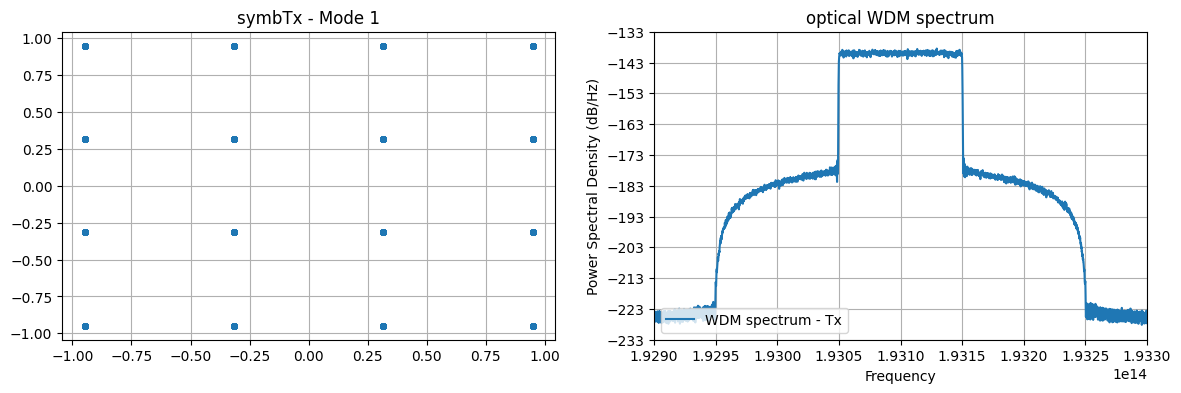

back-to-back connection.


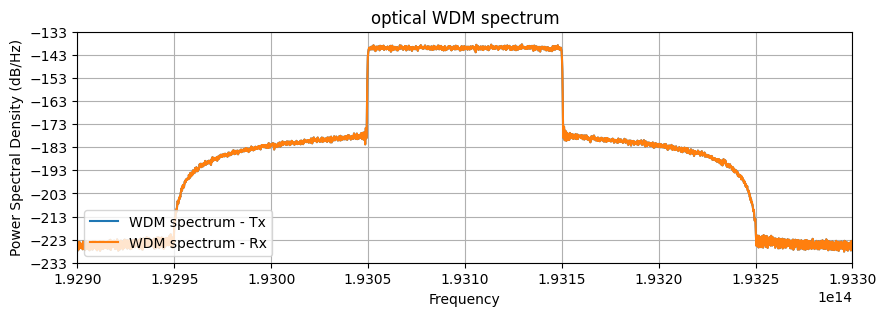

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm

Local oscillator
 - Power: 10.00 dBm
 - LineWidth: 200.00 kHz
 - Frequency offset: 0.00 MHz
[0.00347417+0.j 0.00326577+0.j 0.00267275+0.j ... 0.00159297+0.j
 0.00195774+0.j 0.00221917+0.j]
[0. 0. 0. ... 0. 0. 0.]
[0.00404529+0.j 0.00428099+0.j 0.00417893+0.j ... 0.00459167+0.j
 0.00457261+0.j 0.00407267+0.j]
[0. 0. 0. ... 0. 0. 0.]


In [1]:
%run "./main_SER.ipynb"

### Modelagem SER

1. Sinal de entrada
$$
\begin{aligned}
E_{1}(t)    &= I(t) + jQ(t) + A \\
E_{2}(t)    &= I(t) + jQ(t) + Ae^{j\frac{\pi}{2}}
\end{aligned}
$$

2. Sinal de saída
$$
\begin{aligned}
R_{1}(t)    &= A^{2} + I(t)^{2} + Q(t)^{2} + 2AI(t) \\
R_{2}(t)    &= A^{2} + I(t)^{2} + Q(t)^{2} + 2AQ(t)
\end{aligned}
$$

3. Modelo ideal (ideal square-law detectors)

\begin{aligned}
R_{1}(t)    &= \left((I(t) + A + jQ(t)    \right) \left(I(t) + A - jQ(t)\right) \\
            &= (I(t) + A)^{2} - jQ(t)(I(t) + A) + jQ(t)(I(t) + A) + Q(t)^{2}\\
            &= A^{2} + I(t)^{2} + Q(t)^{2} + 2AI(t) \\
\end{aligned}
$$

\begin{aligned}
R_{2}(t)    &= \left((I(t) + j(Q(t) + A)\right) \left((I(t) - j(Q(t) + A)\right) \\
            &= I(t)^{2} -jI(Q(t) + A) + jI(Q(t) + A) + Q^{2} + 2AQ(t) + A^{2} \\
            &= A^{2} + I(t)^{2} + Q(t)^{2} + 2AQ(t)
\end{aligned}
$$

$\rightarrow 2AI(t) \ e \ 2AQ(t)$: termos de detecção úteis
$\\ \rightarrow (I(t)^{2} + Q(t)^{2})$: signal-signal beat interference (SSBI)

In [12]:
import sympy as sp
from IPython.display import Math, display
from sympy import Matrix, zeros

t, ω_c, ω_lo, ϕ_lo, Δω, Δϕ = sp.symbols('t, ω_c, ω_{LO}, ϕ_{LO}, Δω, Δϕ', real=True)
P_s, P_lo, R = sp.symbols('P_s, P_{LO}, R_d', real=True, positive=True)

A = sp.Function('A', real=True)(t)
II = sp.Function('I', real=True)(t)
Q = sp.Function('Q', real=True)(t)
ϕ = sp.Function('ϕ', real=True)(t)

π = sp.pi
j = sp.I

# função para print de expressões simbólicas
def symdisp(expr, var, unit=' '):
    '''
    Latex style display of sympy expressions
    
    :param expr: expression in latex [string]
    :param var: sympy variable, function, expression.
    :param unit: string indicating unit of var [string]
    '''
    display(Math(expr+sp.latex(var)+'\;'+unit))

In [14]:
# Validação do SER

def SER(Ein):
    """
    Single-Ended photodetector (SER)

    :param Ein: input - IQ signal
    :param Eout: output - detected analog signals
    """
    Eout = Ein*sp.conjugate(Ein)
    
    return Eout
    
E1_ser = (II + j*Q) + A
E2_ser = (II + j*Q) + j*A

symdisp('E1_{ser} =', E1_ser)
symdisp('E2_{ser} =', E2_ser)

R1_ser = SER(E1_ser).as_real_imag()
R2_ser = SER(E2_ser).as_real_imag()

symdisp('R1_{ser} =', R1_ser)
symdisp('R2_{ser} =', R2_ser)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Validação da híbrida + SER

# híbrida
def hybrid(E1, E2):
    T = Matrix(
        [
            [ 1  / 2,  1j / 2,  1j / 2, -1  / 2],
            [ 1j / 2, -1  / 2,  1  / 2,  1j / 2],
            [ 1j / 2,  1  / 2, -1j / 2, -1  / 2],
            [-1  / 2,  1j / 2, -1  / 2,  1j / 2],
        ]
    )
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vetor 4x1
    
    Eo = T*Ei 
    
    return Ei, Eo

def SER(Ein):
    """
    Single-Ended photodetector (SER)

    :param Ein: input - IQ signal
    :param Eout: output - detected analog signals
    """
    Eout = Ein*sp.conjugate(Ein)
    
    return Eout


# hybrid 2x2
def SEReceiver(Es, Elo, Rd=1):
    """
    Single polarization single-ended coherent receiver (SER)

    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]

    :return: downconverted signal after single-ended photodetector
    """
    assert Rd > 0, "PD responsivity should be a positive scalar"
    assert Es.size == Elo.size, "Es and Elo need to have the same size"

    # optical 2 x 4 90° hybrid
    Eo = hybrid(Es, Elo)
    
    E1 = Eo[1]
    E2 = Eo[2]

    # single-ended photodetection
    R1 = SER(E1, Rd)
    R2 = SER(E2, Rd)

    return R1, R2


E_s = (II + j*Q)
E_lo = A
symdisp('E_s(t) =', E_s)
symdisp('E_{LO}(t) =', E_lo)

Ei, Eo = hybrid(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Ei)

print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)
symdisp('E_o = ', Eo.as_real_imag())

R2_ser = SER(Eo[1])
R3_ser = SER(Eo[2])

print('Saída analógica dos SER:')
symdisp('R2_{ser} =', R2_ser.as_real_imag())
symdisp('R3_{ser} =', R3_ser.as_real_imag())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Entrada óptica da híbrida:


<IPython.core.display.Math object>

Saída óptica da híbrida:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Saída analógica dos SER:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
# Validação da híbrida + SER

def hybrid(E1, E2):  
    # T1 = Matrix([[1, j, 0, 0],
    #              [j, 1, 0, 0],
    #              [0, 0, 1, j],
    #              [0, 0, j, 1]])
    
    # T2 = Matrix([[1, 0, 0, 0],
    #              [0, 0, 1, 0],
    #              [0, 1, 0, 0],
    #              [0, 0, 0, j]])
    
    # T3 = Matrix([[1, j, 0, 0],
    #              [j, 1, 0, 0],
    #              [0, 0, 1, j],
    #              [0, 0, j, 1]])
    
    T = Matrix(
        [
            [1 / 2, 1j / 2, 1j / 2, -1 / 2],
            [1j / 2, -1 / 2, 1 / 2, 1j / 2],
            [1j / 2, 1 / 2, -1j / 2, -1 / 2],
            [-1 / 2, 1j / 2, -1 / 2, 1j / 2],
        ]
    )
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vetor 4x1
    
    Eo = T*Ei 
    
    return Ei, Eo

#E_s = sp.sqrt(P_s)*A*sp.exp(j*(ω_c*t + ϕ))
E_s = sp.sqrt(2) * (II + j*Q)

#E_lo = sp.sqrt(P_lo)*sp.exp(j*(ω_lo*t + ϕ_lo))
E_lo = sp.sqrt(2) * A

symdisp('E_s(t) =', E_s)
symdisp('E_{LO}(t) =', E_lo)

Ei, Eo = hybrid(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Ei)

print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)
symdisp('E_o = ', Eo.as_real_imag())

# R1_ser = SER(Eo[0]).as_real_imag()
# R2_ser = SER(Eo[1]).as_real_imag()
# R3_ser = SER(Eo[2]).as_real_imag()
# R4_ser = SER(Eo[3]).as_real_imag()

# print('Saída analógica dos SER:')
# symdisp('R1_{ser} =', R1_ser)
# symdisp('R2_{ser} =', R2_ser)
# symdisp('R3_{ser} =', R3_ser)
# symdisp('R4_{ser} =', R4_ser)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Entrada óptica da híbrida:


<IPython.core.display.Math object>

Saída óptica da híbrida:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# híbrida
def hybrid(Ein, Elo):  
    E1 = (Ein + Elo)/sp.sqrt(2)
    E2 = (Ein + j*Elo)/sp.sqrt(2)    
    return E1, E2

E_s = sp.sqrt(2) * (II + j*Q)
E_lo = sp.sqrt(2) * A

symdisp('E_s(t) =', E_s)
symdisp('E_{LO}(t) =', E_lo)

E1, E2 = hybrid(E_s, E_lo)
    
print('Saída óptica da híbrida/Entrada óptica dos SER:')
symdisp('E_1 = ', E1)
symdisp('E_2 = ', E2)

R1_ser = SER(E1)
R2_ser = SER(E2)

print('Saída analógica dos SER:')
symdisp('R1_{ser} =', R1_ser.as_real_imag())
symdisp('R2_{ser} =', R2_ser.as_real_imag())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Saída óptica da híbrida/Entrada óptica dos SER:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Saída analógica dos SER:


<IPython.core.display.Math object>

<IPython.core.display.Math object>